<a href="https://colab.research.google.com/github/elizabethts/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

It may be helpful to use PCA to reduce the dimensions of your data first in order to obtain --but then again, maybe not. I dunno, you're the data scientist, you tell me.🤪 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [2]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.dtypes


id                           int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [0]:
df = df.drop(['Unnamed: 32','id'], axis = 'columns')

In [5]:
df.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

# You take it from here!

See what you can come up with. You have all the know-how! 

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to do PCA on this data to see if that helps you find distinct linearly-separable clusters.
  - (In the real world, truly linearly-separable clusters are rare.)
- You might want to use an elbow chart to decide on the number of clusters to use.
- You might want to use a scree plot to decide how many principal components to include in your clustering.
- You might want to standardize your data before PCA (If you decide to use PCA). 

## Manage your time and don't spend it all on data exploration or something like that. You got this!

In [0]:
#standardize data

features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']


x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [7]:
#do a PCA on all columns
pca = PCA(n_components = 30)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(principal_components, 
                     columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7'
                            , 'PC8','PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14'
                            ,'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'
                            ,'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26'
                            ,'PC27', 'PC28', 'PC29', 'PC30'])


pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214


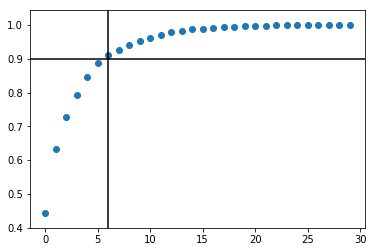

In [8]:
#scree plot
xvals = range(30)
yvals = pca.explained_variance_ratio_.cumsum()

plt.scatter(xvals,yvals);
plt.axhline(.9, color ='black')
plt.axvline(6, color ='black')
plt.show()

#the first 6 components cover 90% of the variance

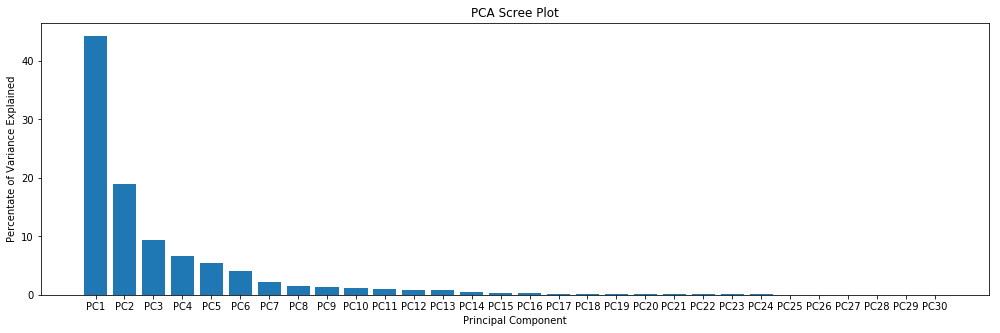

In [9]:
#another scree plot
plt.figure(figsize = (17,5))
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7'
          , 'PC8','PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14'
          ,'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'
          ,'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26'
          ,'PC27', 'PC28', 'PC29', 'PC30']
plt.bar(x= columns, height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

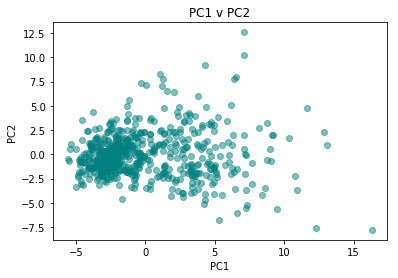

In [10]:
#plot the first two components

xvals = pca_df['PC1']
yvals = pca_df['PC2']
plt.scatter(xvals,yvals, color = 'teal', alpha=0.5)

plt.title('PC1 v PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [0]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_df)
    sum_of_squared_distances.append(km.inertia_)

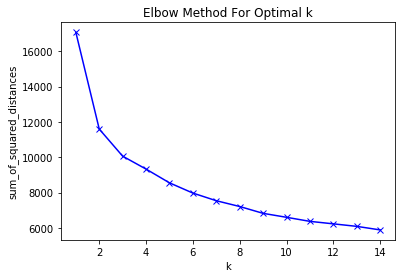

In [12]:
#find optimal k
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [13]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_df)
labels = kmeans.labels_


labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [14]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)

pca_df['clusters'] = new_series.values
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,clusters
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169,1
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868,1
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751,1
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937,1
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214,1


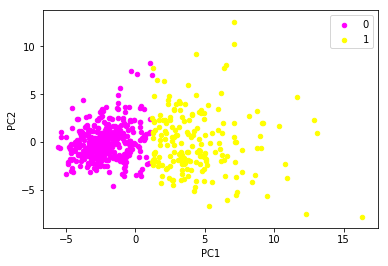

In [15]:
#visualize 2 pca components
colors = {0:'magenta', 1:'yellow', 2:'green', 3:'yellow', 4:'orange'}
fig, ax = plt.subplots()
grouped = pca_df.groupby('clusters')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='PC1', y='PC2', label=key, color=colors[key])
plt.show()   


In [0]:
# Calculate the Nearest Centroid to each data point
def find_nearest_centroid(df, centroids, iteration):
 
  # calculate the distances between each point and each centroid
  distances = distance.cdist(df, centroids, 'euclidean')
  
  # Get nearest centroid to each point based on distance
  nearest_centroids = np.argmin(distances, axis=1)

  se = pd.Series(nearest_centroids)
  df['cluster_'+iteration] = se.values
  
  return df

In [24]:
centroids = pca_df.sample(2)
first_pass = find_nearest_centroid(pca_df.select_dtypes(exclude='int64'), centroids, '1')
first_pass.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,clusters,cluster_1
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116,-0.265471,-0.549563,-0.133768,0.345565,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169,1,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809,-0.017212,0.318297,0.247565,-0.114133,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868,1,1
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111,0.190918,-0.087975,0.392626,-0.204532,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751,1,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370,0.482634,-0.035875,0.026748,-0.464734,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937,1,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606,0.133142,-0.018714,-0.461436,0.065495,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214,1,0


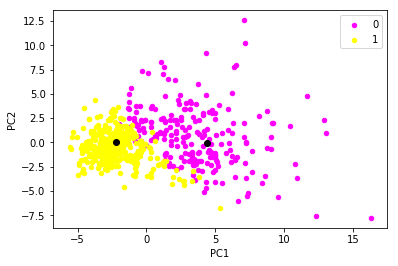

In [48]:
def plot_clusters(df, column_header, centroids):
  colors = {0:'magenta', 1:'yellow', 2:'green'}
  fig, ax = plt.subplots()
  ax.plot(centroids.iloc[0].PC1, centroids.iloc[0].PC2, "ok")
  ax.plot(centroids.iloc[1].PC1, centroids.iloc[1].PC2, "ok")
  grouped = df.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='PC1', y='PC2', label=key, color=colors[key])
  plt.show()
  
plot_clusters(first_pass, 'cluster_1', centroids)

In [0]:
def get_centroids(df, column_header):
  new_centroids = df.groupby(column_header).mean()
  return new_centroids


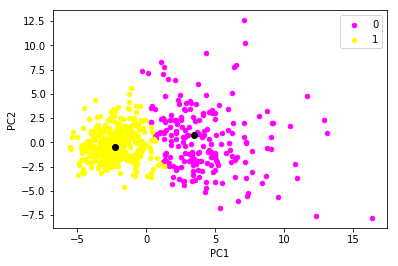

In [58]:
# Calculate New Centroids
centroids = get_centroids(first_pass, 'cluster_1')

# Get Clusters for New Centroids
second_pass = find_nearest_centroid(first_pass.select_dtypes(exclude='int64'), centroids, '2')

# Plot New Cluster
plot_clusters(second_pass, 'cluster_2', centroids)

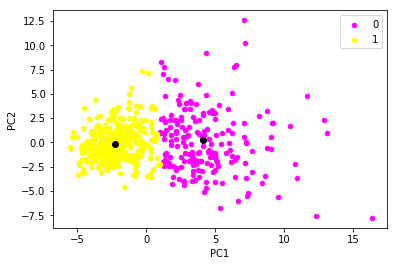

In [50]:
# Calculate New Centroids
centroids = get_centroids(second_pass, 'cluster_2')

# Get Clusters for New Centroids
third_pass = find_nearest_centroid(second_pass.select_dtypes(exclude='int64'), centroids, '3')

# Plot New Cluster
plot_clusters(third_pass, 'cluster_3', centroids)

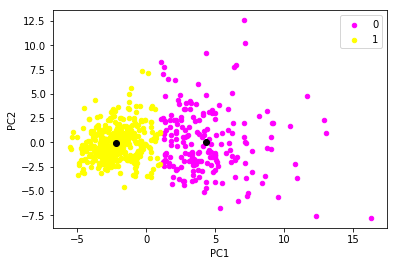

In [51]:
# Calculate New Centroids
centroids = get_centroids(third_pass, 'cluster_3')

# Get Clusters for New Centroids
fourth_pass = find_nearest_centroid(third_pass.select_dtypes(exclude='int64'), centroids, '4')

# Plot New Cluster
plot_clusters(fourth_pass, 'cluster_4', centroids)

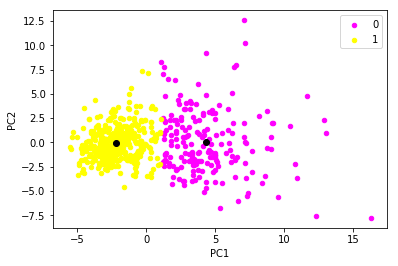

In [52]:
# Calculate New Centroids
centroids = get_centroids(fourth_pass, 'cluster_4')

# Get Clusters for New Centroids
fifth_pass = find_nearest_centroid(fourth_pass.select_dtypes(exclude='int64'), centroids, '5')

# Plot New Cluster
plot_clusters(fifth_pass, 'cluster_5', centroids)

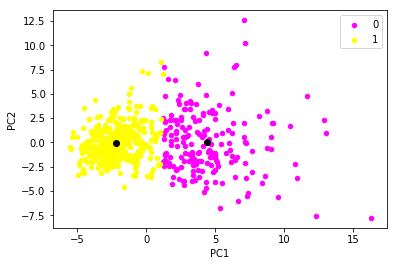

In [53]:
# Calculate New Centroids
centroids = get_centroids(fifth_pass, 'cluster_5')

# Get Clusters for New Centroids
sixth_pass = find_nearest_centroid(fifth_pass.select_dtypes(exclude='int64'), centroids, '6')

# Plot New Cluster
plot_clusters(sixth_pass, 'cluster_6', centroids)

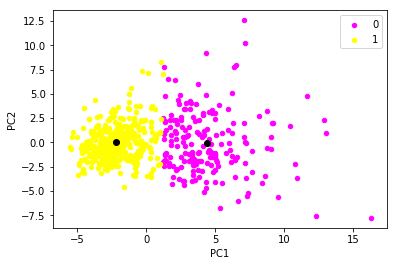

In [54]:
# Calculate New Centroids
centroids = get_centroids(sixth_pass, 'cluster_6')

# Get Clusters for New Centroids
seventh_pass = find_nearest_centroid(sixth_pass.select_dtypes(exclude='int64'), centroids, '7')

# Plot New Cluster
plot_clusters(seventh_pass, 'cluster_7', centroids)

In [56]:
convergence = np.array_equal(sixth_pass['cluster_6'], seventh_pass['cluster_7'])

print("Are we at convergence?? - ", convergence)

Are we at convergence?? -  True


# Stretch Goal:

Once you are satisfied with your clustering, go back and add back in the labels from the original dataset to check how accurate your clustering was. Remember that this will not be a possibility in true unsupervised learning, but it might be a helpful for your learning to be able to check your work against the "ground truth". Try different approaches and see which one is the most successful and try understand why that might be the case. If you go back and try different methods don't ever include the actual "diagnosis" labels in your clustering or PCA.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.